In [2]:
import numpy as np
import pysindy as ps
import networkx as nx
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [3]:
def bio(data, t):
    F = 5
    B = 1
    R = 3
    
    n = len(data)
    result = np.empty(n)
    
    for i in range(0,n):
        sigma = 0
        for j in range (0,n):
            sigma = sigma + R*(adjacency[i,j])*data[i]*data[j]
        result[i] = F - B*data[i] - sigma
    
    return result

In [4]:
library_functions = [
    lambda : 1,
    lambda x : x,
    lambda x,y : x*y
]
library_function_names = [
    lambda : 1,
    lambda x : x,
    lambda x,y : '' + x + '.' + y
]

"""
input:
    an array with len=number_of_nodes
output: 
    and array with len=len(custom_library.get_feature_names())
example:
    input = [0., 0., 1., 1,]
    output = [1, data[0], data[1], data[2], data[3], 
            data[0]*data[1], data[0]*data[2], data[0]*data[3],
            data[1]*data[2], data[1]*data[3], data[2]*data[3]]
"""
def library_parser(data):
    n = len(data)
    result = [None] * int(1 + n + n*(n-1)/2)
    result[0] = 1
    for i in range(0,n):
        result[i+1] = data[i]
    index = 0
    for i in range(0,n):
        for j in range(i+1,n):
            index += 1
            result[n+index] = data[i]*data[j]
    return result

In [5]:
number_of_nodes = 10
#graph = nx.erdos_renyi_graph(number_of_nodes, 0.2)
#graph = nx.connected_watts_strogatz_graph(number_of_nodes, 4, 0.9)
graph = nx.scale_free_graph(number_of_nodes)
adjacency = nx.to_numpy_matrix(graph).A

dt = .01

t_train = np.arange(0, 100, dt)
x0_train = np.random.rand(number_of_nodes) * 10
x_train = odeint(bio, x0_train, t_train)

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

model = ps.SINDy(feature_library=custom_library)
model.fit(x_train, t=dt)
model.print()

x0' = -8948718.983 x2 + 12485591.774 x4 + -12157728.483 x6 + 2364311.522 x7 + 234329.140 x0.x3 + -652126.136 x0.x4 + -3817156.246 x0.x5 + 6110394.132 x0.x6 + -1836685.861 x0.x7 + -755673.637 x0.x8 + 2147141.180 x1.x2 + -14514685.745 x1.x4 + 6661345.991 x1.x5 + 2448624.966 x1.x6 + 587365.670 x1.x9 + -835888.474 x2.x3 + 363759.284 x2.x4 + -684599.802 x2.x7 + 4510286.691 x2.x8 + -22370714.098 x3.x4 + 1123842.535 x3.x6 + -103856.524 x3.x7 + -375965.882 x3.x8 + 514792.629 x4.x5 + -637805.463 x4.x7 + 26907944.693 x4.x8 + 2576217.967 x5.x6 + -443127.777 x5.x7 + -5097478.480 x5.x9 + -52301.915 x6.x7 + 862090.146 x6.x8 + 33302.187 x6.x9 + 52492.668 x7.x9
x1' = 1.678 x6 + -0.917 x1.x2 + -0.430 x2.x5 + 0.209 x2.x9 + 0.201 x4.x6 + -0.100 x6.x8 + -0.187 x6.x9
x2' = -14683674.483 x1 + -137005644.332 x2 + 6356654.894 x3 + 86625698.695 x4 + 43610014.498 x5 + -44368411.177 x6 + 17558873.397 x7 + -41399650.531 x0.x2 + 13952258.473 x0.x3 + 39008074.055 x0.x4 + 10467830.863 x0.x5 + -3639729.461 x0.x6 + -4

In [7]:
def find_steady_state(X):
    prev_state = X[0]
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        prev_state = state
        if -0.0001 < max(np.amax(diff), np.amin(diff), key=abs) < 0.0001:
            return state

real_steady_state = find_steady_state(x_train)        
        
def bio_sindy(data, t):
    cf = library_parser(data)
    result = np.empty(len(data))
    for index in range(0, len(data)):
        sum = 0
        for i in range(0, len(cf)):
            sum += coefficients[index][i] * cf[i]
        result[index] = sum
    return result

coefficients = model.coefficients()
x_test = odeint(bio_sindy, x0_train, t_train)
sindy_steady_state = find_steady_state(x_test)

print('real_steady_state:', real_steady_state)
print('sindy_steady_state:', sindy_steady_state)

real_steady_state: [0.53360381 1.39460193 0.86178168 1.92620948 0.96410571 1.39465036
 0.96441217 0.9644358  1.92476993 1.92020855]
sindy_steady_state: [0.86168486 1.92243971 0.96414975 1.3946789  0.96449934 0.96449934
 1.92243971 1.92243971 0.5336206  1.3946789 ]


In [9]:
alpha = 0.5
perturbed_node = 1
perturbation = np.zeros(number_of_nodes)
perturbation[perturbed_node] = sindy_steady_state[perturbed_node] * alpha
perturbed = np.add(sindy_steady_state, perturbation)

t_perturbed = np.arange(0, 100, dt)
x_perturbed = odeint(bio_sindy, perturbed, t_perturbed)
perturbed_steady_state = find_steady_state(x_perturbed)

print('perturbed_steady_state:', perturbed_steady_state)

perturbed_steady_state: [2.68146685 2.68145985 2.68145302 2.68144636 2.68143987 2.68143354
 2.68142737 2.68142135 2.68141548 2.68140976]


In [10]:
def flow(X):
    prev_state = X[0]
    result = np.empty((0,len(prev_state)))
    for i in range(1,len(X)):
        state = X[i]
        diff = np.subtract(state, prev_state)
        result = np.vstack((result, diff))
        prev_state = state
        if -0.05 < max(np.amax(diff), np.amin(diff), key=abs) < 0.05:
            return result
    print('chaos state')
    return result
        
x_flow = flow(x_perturbed)

<Figure size 1152x648 with 0 Axes>

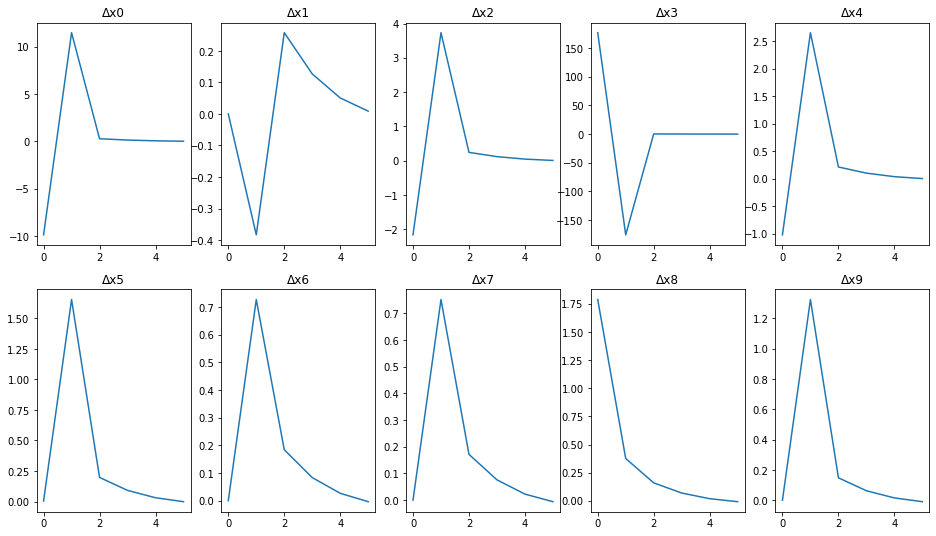

In [11]:
fpr = 5
plt.rcParams["figure.figsize"] = (16, 9)

plt.figure(1)
fig, axs = plt.subplots(int(number_of_nodes/fpr), fpr)
for i in range(0,number_of_nodes):
    axsi = axs[int(i/fpr), i%fpr]
    axsi.plot(x_flow[:,i])
    axsi.set_title('\u0394x'+str(i))
#     axsi.set_ylim(0.1,-0.1)
    

plt.show()

In [12]:
graph.degree

DiMultiDegreeView({0: 11, 1: 4, 2: 7, 3: 1, 4: 2, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1})

In [24]:
g_matrix = np.empty((number_of_nodes,number_of_nodes))
alpha = 0.5
t_perturbed = np.arange(0, 10, dt)
for i in range(0, number_of_nodes):
    perturbation_i = np.zeros(number_of_nodes)
    perturbation_i[i] = sindy_steady_state[i] * alpha
    perturbed_i = np.add(sindy_steady_state, perturbation)
    
    x_perturbed_i = odeint(bio_sindy, perturbed_i, t_perturbed)
    final_state_i = x_perturbed_i[-1]
    diff_i = np.subtract(final_state_i, sindy_steady_state)
    
    dxi_xi = diff_i[i]/sindy_steady_state[i]
    for j in range(0, number_of_nodes):
        dxj_xj = diff_i[j]/sindy_steady_state[j]
        g_matrix[i,j] = abs(dxi_xi/dxj_xj)

print(g_matrix)

[[1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000]
 [7.19568812e-146 1.00000000e+000 6.36373604e+073 2.13448935e+004
  3.02380874e+019 6.60478452e-208 8.24652544e-193 5.06046707e-035
  2.22342185e-117 6.36373604e+073]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000]
 [3.37115204e-150 4.68496131e-005 2.98138571e+069 1.00000000e+000
  1.41664270e+015 3.09431599e-212 3.86346526e-197 2.37080924e-039
  1.04166453e-121 2.98138571e+069]
 [1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
  1.00000000e+000 1.00000000e+000]
 [1.08946599e+062 1.51405394e+207 9.63503960e+280 3.23173199e+211
  4.57820953e+226 1.00000000e+000 1.24856843e+015 7.66182008e+172
  3.36638060e+090 9.63503960e+280

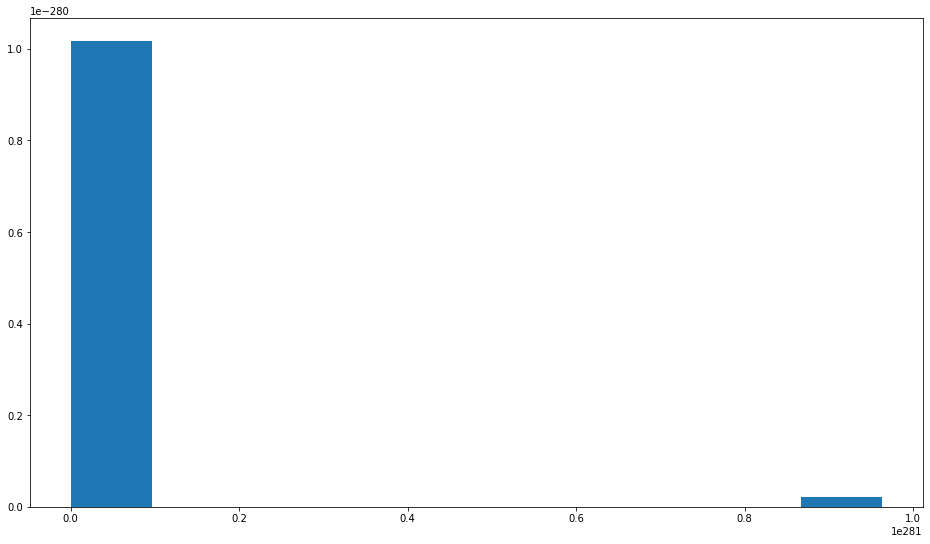

In [25]:
g_dist = []
for row in g_matrix:
    for gij in row:
            g_dist.append(gij)
count, bins, patches = plt.hist(g_dist, density=True)
plt.show()

In [26]:
f = np.zeros(number_of_nodes)
for i in range(0, number_of_nodes):
    f_i = np.zeros(number_of_nodes)
    for n in range(0, number_of_nodes):
        sum_gmn = 0
        for m in range(0, number_of_nodes):
            sum_gmn += g_matrix[m,n]
        sum_gmi = 0
        for m in range(0, number_of_nodes):
            if i==j:
                continue
            sum_gmi += g_matrix[m,i]/sum_gmn
        f_i[n] = g_matrix[i,n] * sum_gmi
    
    for n in range(0, number_of_nodes):
        if i==j:
            continue
        f[i] += f_i[n]
    f[i] /= (number_of_nodes-1)

print(f)

[2.01752961e+060 1.01851852e+000 1.78426659e+279 1.01851852e+000
 8.47816579e+224 6.11111111e+000 2.31216376e+013 1.01851852e+000
 6.23403814e+088 0.00000000e+000]
